# Lotka-Volterra ABC
Examples of ABC algorithms from Toni et al. 2009 'Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems'.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Generate noisy dataset

In [239]:
def lotka_volterra(a, b, xi, yi):
    dt = 0.1
    t_max = 10
    x = np.zeros(int(t_max/dt)+2)
    y = np.zeros(int(t_max/dt)+2)
    t = np.zeros(int(t_max/dt)+2)
    x[0] = xi
    y[0] = yi
    t[0] = 0
    count = 0
    while t[count] < t_max:
        dx = (a * x[count] - x[count] * y[count]) * dt
        dy = (b * x[count] * y[count] - y[count]) * dt
        x[count + 1] = x[count] + dx
        y[count + 1] = y[count] + dy
        t[count + 1] = t[count] + dt
        count = count + 1
    return x, y, t 

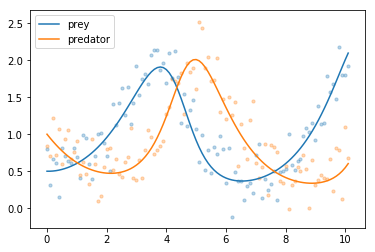

In [3]:
x, y, t = lotka_volterra(1, 1, 0.5, 1)
plt.plot(t, x, label = 'prey')
plt.plot(t, y, label = 'predator')

x_noise = x + np.random.normal(0, np.square(0.5), size=len(x))
y_noise = y + np.random.normal(0, np.square(0.5), size=len(y))
plt.scatter(t, x_noise, s = 10, alpha = 0.3)
plt.scatter(t, y_noise, s = 10, alpha = 0.3)

plt.legend()
plt.show()

# ABC rejection sampler
1. Sample $\theta^*$ from $\pi(\theta)$.
2. Simulate dataset $x^*$ from $f(x|\theta^*)$.
3. If $d(x_0,x^*)<\epsilon$, accept $\theta^*$.
4. Return to #1.

In [4]:
def distance(x_noise, y_noise, x_sim, y_sim):
    return np.sum(np.square(x_sim - x_noise) + np.square(y_sim - y_noise))

In [5]:
dist_limit = distance(x_noise, y_noise, x, y)
accept = 1000
a_accept = np.zeros(accept)
b_accept = np.zeros(accept)
generations = 0
count = 0
while count < accept:
    a_prop, b_prop = np.random.uniform(0.1,1.5,2)
    x_sim, y_sim, t_sim = lotka_volterra(a_prop, b_prop, 0.5, 1)
    d = distance(x_noise, y_noise, x_sim, y_sim)
    if d < dist_limit * 1.5:
        a_accept[count] = a_prop
        b_accept[count] = b_prop
        count = count + 1
    generations = generations + 1

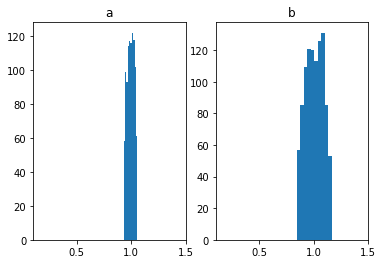

Generations: 61416
Acceptance rate: 0.016282401979940082


In [333]:
plt.subplot(1,2,1)
plt.hist(a_accept)
plt.title('a')
plt.xlim(0.1,1.5)
plt.subplot(1,2,2)
plt.hist(b_accept)
plt.title('b')
plt.xlim(0.1,1.5)
plt.show()

print('Generations: ' + str(generations))
print('Acceptance rate: ' + str(accept/generations))

# ABC MCMC
1. Initialize $\theta_i$, $i=0$.
2. Propose $\theta^*$ from a proposal function $q(\theta|\theta^*)$.
3. Simulate dataset $x^*$ from $f(x|\theta^*)$.
4. If $d(x_0,x^*)<\epsilon$, go to #5, otherwise set $\theta_{i+1}=\theta_i$.
5. Set $\theta_{i+1}=\theta^*$ with probability $\alpha=min\left(1,\frac{\pi(\theta^*)q(\theta_i|\theta^*)}{\pi(\theta_i)q(\theta^*|\theta_i)}\right)$ and $\theta_{i+1}=\theta_i$ with probability $1-\alpha$.
6. Set $i=i+1$ and go to #2.

In [7]:
def proposal(a_c, b_c):
    a_prop = np.random.normal(loc=a_c,scale=0.1)
    b_prop = np.random.normal(loc=b_c,scale=0.1)
    return a_prop, b_prop

In [52]:
def alpha(a_prop, b_prop, a_i, b_i):
    n1 = stats.uniform(0.1,1.5).pdf(a_prop)*stats.uniform(0.1,1.5).pdf(b_prop)
    n2 = stats.norm(a_prop,0.2).pdf(a_i)*stats.norm(b_prop,0.2).pdf(b_i)
    d1 = stats.uniform(0.1,1.5).pdf(a_i)*stats.uniform(0.1,1.5).pdf(b_i)
    d2 = stats.norm(a_i,0.2).pdf(a_prop)*stats.norm(b_i,0.2).pdf(b_prop)
    return min(1, (n1*n2)/(d1*d2))

In [55]:
iterations = 1000
a_chain = np.zeros(iterations)
b_chain = np.zeros(iterations)
a_chain[0], b_chain[0] = np.random.uniform(0.1,1.5,2)
for i in range(iterations-1):
    a_prop, b_prop = proposal(a_chain[i], b_chain[i])
    x_sim, y_sim, t_sim = lotka_volterra(a_prop, b_prop, 0.5, 1)
    d = distance(x_noise, y_noise, x_sim, y_sim)
    if d < dist_limit * 2:
        alpha_prob = alpha(a_prop, b_prop, a_chain[i], b_chain[i])
        a_chain[i+1] = np.random.choice([a_prop,a_chain[i]],1,p=[alpha_prob,1-alpha_prob])
        b_chain[i+1] = np.random.choice([b_prop,b_chain[i]],1,p=[alpha_prob,1-alpha_prob])
    else:
        a_chain[i+1] = a_chain[i]
        b_chain[i+1] = b_chain[i]

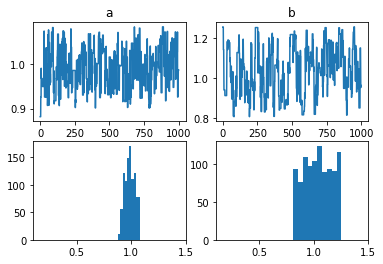

In [56]:
plt.subplot(2,2,1)
plt.plot(a_chain)
plt.title('a')
plt.subplot(2,2,2)
plt.plot(b_chain)
plt.title('b')
plt.subplot(2,2,3)
plt.hist(a_chain)
plt.xlim(0.1,1.5)
plt.subplot(2,2,4)
plt.hist(b_chain)
plt.xlim(0.1,1.5)
plt.show()

# ABC SMC
1. Initialize $\epsilon_1, \epsilon_2, ..., \epsilon_T$. Set the population indicator $t=0$.
2. Set the particle indicator $i=1$.
3. If $t=0$, sample $\theta^{**}$ independently from $\pi(\theta)$. Else, sample $\theta^*$ from the previous population ${\theta^{(i)}_{t-1}}$ with weights $w_{t-1}$ and perturb the particle to obtain $\theta^{**}\sim K_t(\theta|\theta^*)$, where $K_t$ is a perturbation kernel. If $\pi(\theta^{**})=0$, return to $3$. Simulate a candidate dataset $x^*\sim f(x|\theta^{**})$. If $d(x^*,x_o)\geq \epsilon_t$, return to $3$.
4. Set $\theta^{(i)}_t=\theta^{**}$ and calculate the weight for particle $\theta^{(i)}_t$ by $$w^{(i)}_t=\left\{ \begin{array}{ll} 1, & if\ t=0, \\ \frac{\pi (\theta^{(i)}_t)}{\sum^N_{j=1}w^{(j)}_{t-1}K_t(\theta^{(j)}_{t-1},\theta^{(i)}_{t})}, & if\ t>0.\end{array} \right.$$ If $i<N$, set $i=i+1$, go to $3$.
5. Normalize the weights. If $t<T$, set $t=t+1$, go to $2$.


In [123]:
def weights(a_chain, b_chain, a_pk, b_pk, w_norm):
    return (stats.uniform(0.1,1.5).pdf(a_chain) * stats.uniform(0.1,1.5).pdf(b_chain)) / (w_norm*a_pk + w_norm*b_pk)

In [124]:
def pkernel(chain,prop):
    return stats.norm(prop,0.2).pdf(chain)

In [325]:
def lotka_volterra(a_prop, b_prop, xi, yi):
    dt = 0.1
    t_max = 10
    x = np.zeros((len(a_prop), int(t_max/dt)+2))
    y = np.zeros((len(a_prop), int(t_max/dt)+2))
    t = np.zeros((int(t_max/dt)+2))
    x[:,0] = xi
    y[:,0] = yi
    count = 0
    while t[count] < t_max:
        dx = (a_prop * x[:,count] - x[:,count] * y[:,count]) * dt
        dy = (b_prop * x[:,count] * y[:,count] - y[:,count]) * dt
        x[:, count + 1] = x[:, count] + dx
        y[:, count + 1] = y[:, count] + dy
        t[count + 1] = t[count] + dt
        count = count + 1
    return x, y, t

In [301]:
def distance(x_noise, y_noise, x_sim, y_sim):
    x_noise_repeat = np.repeat([x_noise],len(x_sim),axis=0)
    y_noise_repeat = np.repeat([y_noise],len(x_sim),axis=0)
    return np.sum(np.square(x_sim - x_noise_repeat) + np.square(y_sim - y_noise_repeat),axis=1)

In [456]:
def plot_hist(a_chain, b_chain):
    plt.subplot(1,2,1)
    plt.hist(a_chain)
    plt.xlim(0.1,1.5)
    plt.title('a')
    plt.subplot(1,2,2)
    plt.xlim(0.1,1.5)
    plt.hist(b_chain)
    plt.title('b')
    plt.show()
    return

In [462]:
populations = 5
epsilon_schedule = np.flip(np.arange(1.5, 1.5 + populations * 0.5, 0.5),axis=0)
dist = dist_limit * epsilon_schedule
N = 10000
particles = N
a_chain = np.random.uniform(0.1, 1.5, particles)
b_chain = np.random.uniform(0.1, 1.5, particles)
w = np.ones(len(a_chain))
w_norm = w / np.sum(w)
population = 1

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


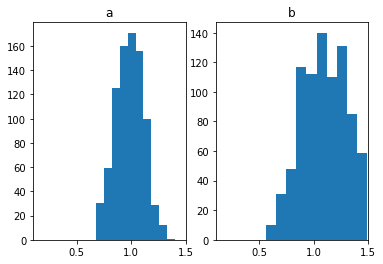

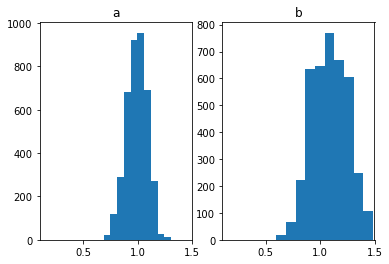

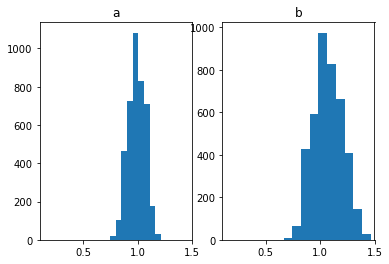

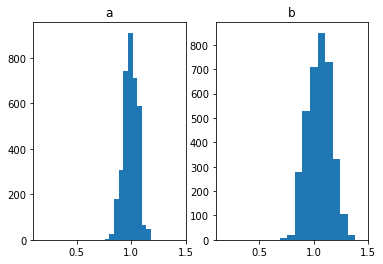

In [463]:
while population < populations:
    a_chain_idx = np.random.choice(range(0,len(a_chain)),size=particles,p=w_norm)
    a_chain_new = [a_chain[i] for i in a_chain_idx]
    b_chain_new = [b_chain[i] for i in a_chain_idx]
    w_norm_new = [w_norm[i] for i in a_chain_idx]
    a_chain = a_chain_new
    b_chain = b_chain_new
    w_norm = w_norm_new
    a_prop, b_prop = proposal(a_chain, b_chain)
    a_pk = pkernel(a_chain, a_prop)
    b_pk = pkernel(b_chain, b_prop)
    w = weights(a_chain, b_chain, a_pk, b_pk, w_norm)
    x_sim, y_sim, t_sim = lotka_volterra(a_prop, b_prop, 0.5, 1)
    d = distance(x_noise, y_noise, x_sim, y_sim)
    acceptance = [z < dist[population - 1] for z in d]
    a_chain = np.extract(acceptance, a_chain)
    b_chain = np.extract(acceptance, b_chain)
    w_norm = np.extract(acceptance, w) / np.sum(np.extract(acceptance, w))
    population = population + 1
    plot_hist(a_chain, b_chain)